In [14]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Código ON/OFF</button>''', raw=True)

Código ON/OFF

In [15]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import plotly.plotly as py
import plotly

from matplotlib.ticker import FuncFormatter
from pandas.tseries.offsets import BDay
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Setting pandas dataframe display options
pd.set_option('display.width', 800)
pd.set_option('max_colwidth', 800)
pd.set_option("display.max_rows", 20)

# Set matplotlib style
plt.style.use('seaborn')

# Set plotly offline
init_notebook_mode(connected=True)

In [16]:
import cufflinks as cf

In [17]:
#### Functions ####
def compute_drawdowns(dataframe):
    """
    Function to compute drawdowns of a timeseries
    """
    return (dataframe / dataframe.cummax() -1) * 100

In [18]:
# Downloading funds and creating quotes and returns dataframes
Begin = "2013-12-31"
End = "2017-08-31"
                           
MSid = ['F00000OZ46', 'F00000Q8QC', 'F0000007LD']
Nomes = ['PimcoINC', 'JupiterDB', 'MG_OI']
fundos = pd.DataFrame()

# Conversão de datetime
conv = time.strptime(Begin,"%Y-%m-%d") 
start_date = time.strftime("%m/%d/%Y",conv)

# Download
for ticker in MSid:
    url = "https://lt.morningstar.com/api/rest.svc/timeseries_price/okhysb8aoh?id=" + str(ticker) + "&currencyId=BAS&idtype=Morningstar&frequency=daily&startDate=" + start_date + "&outputType=CSV"
    fundo = pd.read_csv(url, sep = ";" , index_col = 'date', parse_dates = True)
    fundo =  fundo.drop('Unnamed: 2', 1)
    fundos = fundos.merge(fundo, left_index = True, right_index = True, how='outer')
    
fundos.columns = Nomes
fundos = fundos.fillna(method='ffill')

# Filtering dataframe from Begin to END
fundos = fundos.loc[:End]

#### Returns ####
returns = (fundos / fundos.shift(1)) - 1

#### Performance dos fundos como se tivessem investido 100 euros em cada em 31-12-2013 (em versão ACC para se ter acesso ao Retorno Total)

In [19]:
#### Normalization to 100 ####
fundos_norm = (fundos / fundos.iloc[0] * 100)
fundos_norm.iplot(kind='scatter',yTitle='Valor por cada 100€ investidos', title='Performance dos fundos')

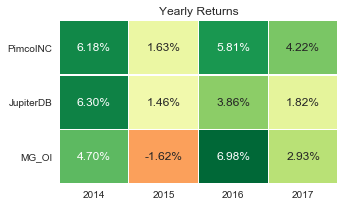

In [20]:
# Resampling to yearly (business year)
yearly_quotes = fundos_norm.resample('BA').last()

# Adding first quote (only if start is in the middle of the year) ### Falta trabalho para automatizar #####
yearly_quotes = pd.concat([fundos_norm.iloc[:1], yearly_quotes])

Start = int(Begin[:4]) -1

# Returns
yearly_returns = ((yearly_quotes / yearly_quotes.shift(1)) - 1) * 100
yearly_returns = yearly_returns.set_index([list(range(Start, 2018))]).drop(Start).drop(Start + 1)

#### Transpose() da matrix de retornos anuais####
returns_transposed = yearly_returns.transpose()

# Yearly returns heatmap
fig, ax = plt.subplots()
fig.set_size_inches(5, 3) # 68%
heatmap = sns.heatmap(returns_transposed, annot=True, cmap="RdYlGn", linewidths=.2, fmt=".2f", cbar=False, center=1)
for t in heatmap.texts: t.set_text(t.get_text() + "%")
plt.title('Yearly Returns')
plt.yticks(rotation=360)
plt.show()

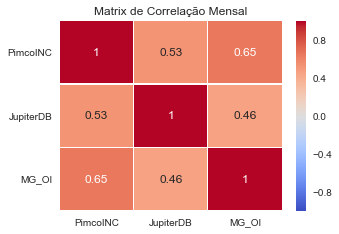

In [21]:
#### Get monthly returns for correlation matrix
Quotes_monthly = fundos_norm.resample('BM').last().copy()
Returns_monthly = (Quotes_monthly / Quotes_monthly.shift(1)) - 1

##### New Preturns (to include Portfolio returns) ####
Preturns = Returns_monthly.copy()

##### Correlation (bonus: Seaborn heatmap)####
Pcorr_matrix = Preturns.corr()
a = -0.5

# Normal heatmap
fig, ax = plt.subplots()
fig.set_size_inches(5, 3.5) # 68%
sns.heatmap(Pcorr_matrix, annot = True, cmap = "coolwarm", linewidths=.2, vmin=-1)
plt.yticks(rotation=360)
plt.title('Matrix de Correlação Mensal')
plt.show()

In [22]:
#### Setting seed for pseudo random number generator ###
np.random.seed(0)

#### Markowitz's Efficient Frontier ####
cov_matrix = returns.cov() * 252
corr_matrix = returns.corr()

num_assets = len(fundos.columns)

pfolio_returns = []
pfolio_volatilities = []
pfolio_weights = []
nportfolios = 25000

def simulation(n):
    for x in range (nportfolios):
            weights = np.random.random(num_assets)
            weights /= np.sum(weights)
            pfolio_weights.append(weights)
            pfolio_returns.append(np.sum(weights * returns.mean()) * 252 * 100 * 1.04)
            pfolio_volatilities.append(np.sqrt(np.dot(weights.T,np.dot(returns.cov() * 252, weights))) * 100)
            
simulation(nportfolios)
                
pfolio_returns = np.array(pfolio_returns)
pfolio_volatilities = np.array(pfolio_volatilities)

# Making a dataframe with the values
portfolios = pd.DataFrame({"Return": pfolio_returns,
                           "Volatility": pfolio_volatilities})

#### Adding Sharpe and weights to portfolios dataframe ####
portfolios["Sharpe"] = portfolios["Return"] / portfolios["Volatility"]
portfolios["Weights"] = pfolio_weights
Sharpe_array = np.array(portfolios['Sharpe'])

# select portfolio with highest sharpe
max_sharpe = portfolios['Sharpe'] > max(portfolios['Sharpe']) - 0.000000001
# Select MVP
MVP = portfolios['Volatility'] == min(portfolios['Volatility'])

Portfolio_max_sharpe = portfolios[max_sharpe]
a = Portfolio_max_sharpe['Volatility']
b = Portfolio_max_sharpe['Return']

##### Os fundos são apenas os 3 discutidos. O software apenas calcula pesos aleatórios para novas carteiras e faz 25 mil pontos de retorno e volatilidade tendo em consideração essas alocações (soma dos pesos sempre igual a 1).

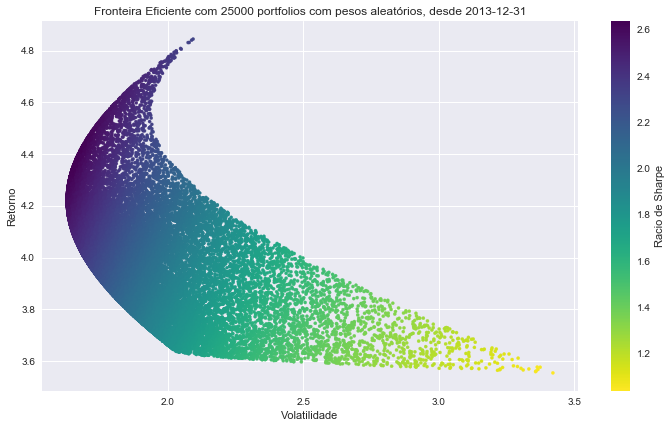

In [23]:
# Ploting on a graph
plt.figure(figsize=(12, 6.8))
plt.scatter(x = portfolios["Volatility"], y = portfolios["Return"], c = Sharpe_array,  cmap = 'viridis_r', s = 10)
plt.colorbar(label='Racio de Sharpe')
plt.ylabel("Retorno")
plt.xlabel("Volatilidade")
plt.xticks(np.arange(2, 4, 0.5))
plt.title(str('Fronteira Eficiente com ' + str(nportfolios) + ' portfolios com pesos aleatórios, desde ' + Begin ))
plt.show()

In [24]:
# Seleccionar retorno e volatilidade desejadas para filtrar os portfolios
Retorno = 8.45
Volatilidade = 8

In [25]:
#### Selecting Portfolios ####
return_target = portfolios['Return'] > Retorno # Filter portfolios by return
volatility_target = portfolios['Volatility'] < Volatilidade # Filter portfolios by volatility
# select portfolio with highest sharpe
max_sharpe = portfolios['Sharpe'] > max(portfolios['Sharpe']) - 0.000000001
# Select MVP
MVP = portfolios['Volatility'] == min(portfolios['Volatility'])

Portfolios_target = portfolios[return_target & volatility_target]
Portfolio_MVP = portfolios[MVP]

#### Nome dos fundos (por ordem de pesos)

In [26]:
pd.DataFrame(Nomes).transpose()

,0,1,2
0,PimcoINC,JupiterDB,MG_OI


###### Portfolio com o maior Rácio de Sharpe (rf = 0)

In [27]:
Portfolio_max_sharpe

,Return,Volatility,Sharpe,Weights
9917,4.36894,1.656491,2.637467,"[0.600040103032, 0.327291493698, 0.0726684032696]"


###### Portfolio com o menor desvio padrão (Minimum Variance Portfolio)

In [28]:
Portfolio_MVP

,Return,Volatility,Sharpe,Weights
982,4.222831,1.628016,2.59385,"[0.479815992051, 0.406835847267, 0.113348160682]"


#### A fronteira eficiente dava um peso semelhante entre o PimcoINC e o JupiterDB mas menor peso ao M&G Optimal Income, daí eu ter optado por uma carteira 40/40/20 respectivamente (também não quis reduzir o M&G a apenas 10% de peso por razões de disversificação). Mas tenho os gráficos para uma carteira com um terço em cada fundo para quem quiser analisar ou preferir.

In [29]:
### weights ####
weights1 = np.array(        [0.334, 0.333, 0.333]            )
weights2 = np.array(     [0.4, 0.4, 0.2]             )

### Calculate Portfolio value with linear algebra ####
fundos["Um terço em cada"] = np.dot(fundos_norm, weights1) # weights1 * quotes
fundos["40/40/20"] = np.dot(fundos_norm, weights2) # weights1 * quotes

carteiras = fundos.iloc[:,3:5]

In [30]:
carteiras.iplot(kind='scatter',yTitle='Valor por cada 100€ investidos', title='Performance das carteiras ACC')

In [31]:
#### Computing Drawdowns ####
DD = round(compute_drawdowns(carteiras), 2)

DD.iplot(kind='scatter', title='Drawdown dos portfolios ACC', yTitle='Percentagem')

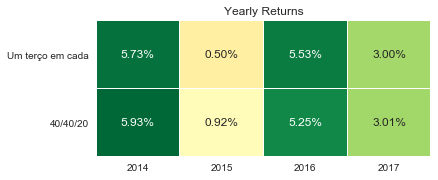

In [32]:
# Resampling to yearly (business year)
yearly_quotes = carteiras.resample('BA').last()

# Adding first quote (only if start is in the middle of the year) ### Falta trabalho para automatizar #####
yearly_quotes = pd.concat([carteiras.iloc[:1], yearly_quotes])

Start = int(Begin[:4]) -1

# Returns
yearly_returns = ((yearly_quotes / yearly_quotes.shift(1)) - 1) * 100
returns = yearly_returns.set_index([list(range(Start, 2018))]).drop(Start).drop(Start + 1)

#### Transpose() da matrix de retornos anuais####
returns = returns.transpose()

# Yearly returns heatmap
fig, ax = plt.subplots()
fig.set_size_inches(6, 2.5) # 68%
heatmap = sns.heatmap(returns, annot=True, cmap="RdYlGn", linewidths=.2, fmt=".2f", cbar=False, center=1)
for t in heatmap.texts: t.set_text(t.get_text() + "%")
plt.title('Yearly Returns')
plt.yticks(rotation=360)
plt.show()

#### Versão INC

In [33]:
# Downloading funds and creating quotes and returns dataframes
Begin = "2013-12-31"
End = "2017-08-31"
                           
MSid = ['F00000OY3P', 'F00000O778', 'F00000Q5CC']
Nomes = ['PimcoINC', 'JupiterDB', 'MG_OI']
fundos = pd.DataFrame()

# Conversão de datetime
conv = time.strptime(Begin,"%Y-%m-%d") 
start_date = time.strftime("%m/%d/%Y",conv)

# Download
for ticker in MSid:
    url = "https://lt.morningstar.com/api/rest.svc/timeseries_price/okhysb8aoh?id=" + str(ticker) + "&currencyId=BAS&idtype=Morningstar&frequency=daily&startDate=" + start_date + "&outputType=CSV"
    fundo = pd.read_csv(url, sep = ";" , index_col = 'date', parse_dates = True)
    fundo =  fundo.drop('Unnamed: 2', 1)
    fundos = fundos.merge(fundo, left_index = True, right_index = True, how='outer')
    
fundos.columns = Nomes
fundos = fundos.fillna(method='ffill')

# Filtering dataframe from Begin to END
fundos = fundos.loc[:End]

#### Returns ####
returns = (fundos / fundos.shift(1)) - 1

#### A versão INC inclui apenas o valor das UPs, excluindo assim as distribuições. O objectivo é termos uma ideia de como o capital investido, e se as distribuições não estão apenas a distribuir o capital do cliente.

In [34]:
#### Normalization to 100 ####
fundos_norm = (fundos / fundos.iloc[0] * 100)
fundos_norm.iplot(kind='scatter',yTitle='Valor por cada 100€ investidos', title='Performance dos fundos INC')

#### Todos os cálculos são feitos com base na compra dos fundos a 2013-12-31. Os preços por UP são estes:

In [35]:
fundos.loc['2013-12-31']

PimcoINC     10.52
JupiterDB    11.01
MG_OI        17.45
Name: 2013-12-31 00:00:00, dtype: float64

#### É verdade que o capital está semelhante em ambas as carteiras (até ligeiramente superior na carteira 'Um terço em cada') mas a carteira 40/40/20 tem vindo a distribuir cerca de mais 0.6 pontos percentuais por ano.

In [36]:
### weights ####
weights1 = np.array(        [0.334, 0.333, 0.333]            )
weights2 = np.array(     [0.4, 0.4, 0.2]             )

### Calculate Portfolio value with linear algebra ####
fundos["Um terço em cada"] = np.dot(fundos_norm, weights1) # weights1 * quotes
fundos["40/40/20"] = np.dot(fundos_norm, weights2) # weights1 * quotes

carteiras = fundos.iloc[:,3:5]

In [37]:
carteiras.iplot(kind='scatter',yTitle='Valor por cada 100€ investidos', title='Performance das carteiras INC')

In [38]:
fundos["40/40/20"].median()

102.03340978585784

In [39]:
#### Código para a produção de ficheiro CSV com o merge das distribuições ####
fundos = fundos.iloc[:,0:3]
montantes = [100, 100, 100]  # Todos os valores a 100 para as distribuições darem em percentagem
UPs = montantes / fundos.loc['2013-12-31']  # Calcular o montantes de Ups compradas por cada 100 euros
montantes_ind = fundos * UPs  # Calcular montantes individuais

In [40]:
#### Ler ficheiros CSV com as distribuições
Jupiter_Div = pd.read_csv('https://raw.githubusercontent.com/LuisSousaSilva/Articles-and-studies/master/INC%20Mutual%20Funds/JupiterINC.csv', sep = ';', index_col = 'date', parse_dates = True)
Pimco_Div = pd.read_csv('https://raw.githubusercontent.com/LuisSousaSilva/Articles-and-studies/master/INC%20Mutual%20Funds/PimcoINC.csv', sep = ';', index_col = 'date', parse_dates = True)
MG_Div = pd.read_csv('https://raw.githubusercontent.com/LuisSousaSilva/Articles-and-studies/master/INC%20Mutual%20Funds/MG_INC.csv', sep = ';', index_col = 'date', parse_dates = True)
MG_Div.drop('Unnamed: 1',axis=1, inplace=True)

HTTPError: HTTP Error 404: Not Found

In [ ]:
#### Fazer o merge das distribuições
dist = Pimco_Div.merge(Jupiter_Div, left_index = True, right_index = True, how='outer')
dist = dist.merge(MG_Div, left_index = True, right_index = True, how='outer')
dist.columns = ['PimcoINC', 'JupiterDB', 'MG_OI']

In [ ]:
#### Calcular os montantes das distribuições em percentagem
dist_m = dist * UPs
distribuicoes = dist_m

In [ ]:
#### Criação do ficheiro CSV com o merge das distribuições
distribuicoes.to_csv('distribuicoes.csv', sep=';')